# EKSTRAKSI FITUR

# Warna (HSV Histogram + Statistik)

In [10]:
import cv2
import numpy as np
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import matplotlib.pyplot as plt
import os 
import re

In [ ]:
# Fungsi ekstraksi fitur warna dari 1 gambar
def extract_color_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Gagal membaca gambar: {image_path}")
        return None, None
    
    # Ubah ke HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Histogram HSV (16, 8, 8 bin)
    h_hist = cv2.calcHist([hsv], [0], None, [16], [0, 180])
    s_hist = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    v_hist = cv2.calcHist([hsv], [2], None, [8], [0, 256])

    # Normalisasi
    h_hist = cv2.normalize(h_hist, h_hist).flatten()
    s_hist = cv2.normalize(s_hist, s_hist).flatten()
    v_hist = cv2.normalize(v_hist, v_hist).flatten()

    # Statistik warna (mean, std, skewness, kurtosis)
    mean_val = np.mean(hsv, axis=(0, 1))
    std_val = np.std(hsv, axis=(0, 1))
    skew_val = skew(hsv.reshape(-1, 3))
    kurt_val = kurtosis(hsv.reshape(-1, 3))

    color_stats = np.concatenate([mean_val, std_val, skew_val, kurt_val])
    feature_vector = np.concatenate([h_hist, s_hist, v_hist, color_stats])

    return feature_vector, (mean_val, std_val, skew_val, kurt_val)


# Fungsi ekstraksi semua gambar dalam folder
def extract_features_from_folder(folder_path):
    all_features = {}
    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(folder_path, fname)
            feats, stats = extract_color_features(img_path)
            if feats is not None:
                all_features[fname] = feats
                mean_val, std_val, skew_val, kurt_val = stats

                print(f"\n✅ {fname} → fitur panjang {len(feats)}")
                print(f"Mean (H, S, V): {mean_val}")
                print(f"Std  (H, S, V): {std_val}")
                print(f"Skew (H, S, V): {skew_val}")
                print(f"Kurt (H, S, V): {kurt_val}")
                print("Nilai fitur (10 pertama):", feats[:10])  # tampilkan sebagian fitur
    return all_features


# Jalankan untuk folder db
folder_path = "db"
features_db = extract_features_from_folder(folder_path)

# Ringkasan hasil
print("\nJumlah gambar yang diekstrak:", len(features_db))


✅ anggur 1.png → fitur panjang 44
Mean (H, S, V): [24.35165356 25.95136572 16.52230542]
Std  (H, S, V): [42.9740314  62.60758032 37.3640725 ]
Skew (H, S, V): [1.44369175 2.87685829 2.60780176]
Kurt (H, S, V): [0.48736205 7.25878204 7.09771753]
Nilai fitur (10 pertama): [0.98930079 0.00288149 0.03937479 0.02141991 0.02283051 0.03446098
 0.01386278 0.01430931 0.04304416 0.11337505]

✅ anggur 10.png → fitur panjang 44
Mean (H, S, V): [43.25077999 34.79716986 50.33873333]
Std  (H, S, V): [52.62987097 48.25425429 69.40783202]
Skew (H, S, V): [0.50932932 1.29055586 1.10682276]
Kurt (H, S, V): [-1.62459625  0.90881325 -0.1642053 ]
Nilai fitur (10 pertama): [0.92136657 0.00294232 0.00950489 0.08513309 0.01726548 0.00421554
 0.0054067  0.00453752 0.0272537  0.29547602]

✅ anggur 11.png → fitur panjang 44
Mean (H, S, V): [44.75903854 38.98019922 37.78782943]
Std  (H, S, V): [56.57323209 65.76385748 56.46715057]
Skew (H, S, V): [0.57949334 1.84607191 1.47387866]
Kurt (H, S, V): [-1.49756494  2.5

# Tekstur (GLCM)

In [ ]:
# Fungsi ekstraksi fitur tekstur dari 1 gambar
def extract_glcm_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Gagal membaca gambar: {image_path}")
        return None, None

    # Konversi ke grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Biar GLCM gak terlalu besar nilainya, ubah jadi 8-bit (0-255)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # Buat GLCM dengan 4 arah
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray, 
                        distances=distances, 
                        angles=angles, 
                        levels=256, 
                        symmetric=True, 
                        normed=True)

    # Hitung 4 properti utama dan ambil rata-ratanya dari 4 arah
    contrast = graycoprops(glcm, 'contrast').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()

    # Gabungkan ke dalam satu vektor fitur
    glcm_features = np.array([contrast, correlation, energy, homogeneity])

    return glcm_features, (contrast, correlation, energy, homogeneity)

# Fungsi untuk ekstrak semua gambar dalam folder
def extract_glcm_from_folder(folder_path):
    all_glcm_features = {}
    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(folder_path, fname)
            feats, stats = extract_glcm_features(img_path)
            if feats is not None:
                all_glcm_features[fname] = feats
                contrast, correlation, energy, homogeneity = stats

                print(f"\n✅ {fname}")
                print(f"Contrast     : {contrast:.4f}")
                print(f"Correlation  : {correlation:.4f}")
                print(f"Energy       : {energy:.4f}")
                print(f"Homogeneity  : {homogeneity:.4f}")
                print("Nilai fitur (GLCM):", feats)
    return all_glcm_features


# Jalankan untuk folder 'db'
folder_path = "db"
glcm_features_db = extract_glcm_from_folder(folder_path)

print("\nJumlah gambar yang diekstrak (GLCM):", len(glcm_features_db))


✅ anggur 1.png
Contrast     : 40.3419
Correlation  : 0.9835
Energy       : 0.7065
Homogeneity  : 0.8305
Nilai fitur (GLCM): [40.34193259  0.98354883  0.7064734   0.83046385]

✅ anggur 10.png
Contrast     : 17.7129
Correlation  : 0.9975
Energy       : 0.5346
Homogeneity  : 0.6919
Nilai fitur (GLCM): [17.71286002  0.99750027  0.53461941  0.69185275]

✅ anggur 11.png
Contrast     : 40.3506
Correlation  : 0.9925
Energy       : 0.5713
Homogeneity  : 0.6811
Nilai fitur (GLCM): [40.35059918  0.99246875  0.57133644  0.68112377]

✅ anggur 12.png
Contrast     : 25.9914
Correlation  : 0.9934
Energy       : 0.3799
Homogeneity  : 0.6645
Nilai fitur (GLCM): [25.99141472  0.99336803  0.37988094  0.66450547]

✅ anggur 13.png
Contrast     : 17.8780
Correlation  : 0.9867
Energy       : 0.7105
Homogeneity  : 0.8059
Nilai fitur (GLCM): [17.87804403  0.98669463  0.71052671  0.80586886]

✅ anggur 14.png
Contrast     : 18.7383
Correlation  : 0.9946
Energy       : 0.6602
Homogeneity  : 0.7413
Nilai fitur (GL

# Bentuk

In [ ]:
# Fungsi ekstraksi fitur bentuk dari 1 gambar
def extract_shape_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Gagal membaca gambar: {image_path}")
        return None, None

    # Ubah ke grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Thresholding Otsu (otomatis cari ambang optimal)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Cari kontur (batas objek)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return np.zeros(6), None  # kalau gak ada kontur, isi nol

    # Ambil kontur dengan area terbesar (anggap itu objek utama)
    c = max(contours, key=cv2.contourArea)

    # --- Hitung fitur bentuk ---
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)

    # Aspect Ratio = lebar / tinggi bounding box
    x, y, w, h = cv2.boundingRect(c)
    aspect_ratio = float(w) / h if h > 0 else 0

    # Extent = area objek / area bounding box
    rect_area = w * h
    extent = float(area) / rect_area if rect_area > 0 else 0

    # Solidity = area objek / area convex hull
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area > 0 else 0

    # Circularity = (4π × area) / (perimeter²)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

    # Gabungkan jadi 1 vektor
    shape_features = np.array([area, perimeter, aspect_ratio, extent, solidity, circularity])

    return shape_features, (area, perimeter, aspect_ratio, extent, solidity, circularity)


# Fungsi ekstraksi semua gambar dalam folder
def extract_shape_from_folder(folder_path):
    all_shape_features = {}
    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(folder_path, fname)
            feats, stats = extract_shape_features(img_path)
            if feats is not None:
                all_shape_features[fname] = feats
                area, perimeter, aspect_ratio, extent, solidity, circularity = stats

                print(f"\n✅ {fname}")
                print(f"Area          : {area:.2f}")
                print(f"Perimeter     : {perimeter:.2f}")
                print(f"Aspect Ratio  : {aspect_ratio:.3f}")
                print(f"Extent        : {extent:.3f}")
                print(f"Solidity      : {solidity:.3f}")
                print(f"Circularity   : {circularity:.3f}")
                print("Nilai fitur (Shape):", feats)
    return all_shape_features


# Jalankan untuk folder db
folder_path = "db"
shape_features_db = extract_shape_from_folder(folder_path)

print("\nJumlah gambar yang diekstrak (Shape):", len(shape_features_db))



✅ anggur 1.png
Area          : 367440.00
Perimeter     : 10071.35
Aspect Ratio  : 0.832
Extent        : 0.407
Solidity      : 0.676
Circularity   : 0.046
Nilai fitur (Shape): [3.67440000e+05 1.00713454e+04 8.32053743e-01 4.06723828e-01
 6.75876023e-01 4.55219984e-02]

✅ anggur 10.png
Area          : 3706897.50
Perimeter     : 20794.28
Aspect Ratio  : 0.642
Extent        : 0.555
Solidity      : 0.679
Circularity   : 0.108
Nilai fitur (Shape): [3.70689750e+06 2.07942798e+04 6.42281463e-01 5.54570116e-01
 6.78585070e-01 1.07729011e-01]

✅ anggur 11.png
Area          : 584364.00
Perimeter     : 23542.94
Aspect Ratio  : 1.414
Extent        : 0.245
Solidity      : 0.419
Circularity   : 0.013
Nilai fitur (Shape): [5.84364000e+05 2.35429370e+04 1.41384615e+00 2.44565163e-01
 4.18892018e-01 1.32486625e-02]

✅ anggur 12.png
Area          : 1267014.00
Perimeter     : 18476.63
Aspect Ratio  : 0.857
Extent        : 0.578
Solidity      : 0.754
Circularity   : 0.047
Nilai fitur (Shape): [1.26701400e

ini bisa hapus aja nanti

hasil ekstraksi itu menggambarkan atau menjelaskan gimana image tersebut dr segi warna, tekstur, dan bentuk dalam bentuk vektor fitur

# Hitung jarak dan cari gambar mirip

In [ ]:
# Hitung jarak (Cosine Distance)
def calculate_distance(vec1, vec2, method='cosine'):
    if method == 'cosine':
        sim = cosine_similarity([vec1], [vec2])[0][0]   # similarity (0–1)
        return 1 - sim  # ubah jadi jarak (0 = sangat mirip)
    elif method == 'euclidean':
        return np.linalg.norm(vec1 - vec2)
    else:
        raise ValueError("Gunakan 'cosine' atau 'euclidean'.")

# Fungsi pencarian gambar mirip (Top-5)
def search_similar_images(query_features, db_features, method='cosine', top_k=5):
    distances = {}
    for name, feat in db_features.items():
        d = calculate_distance(query_features, feat, method)
        distances[name] = d
    sorted_imgs = sorted(distances.items(), key=lambda x: x[1])  # jarak kecil = mirip
    return sorted_imgs[:top_k]

# Gabungkan semua fitur (warna + tekstur + bentuk)
def combine_features(color_feat, glcm_feat, shape_feat, w_color=0.4, w_glcm=0.3, w_shape=0.3):
    if color_feat is None:
        color_feat = np.zeros(1)
    if glcm_feat is None:
        glcm_feat = np.zeros(1)
    if shape_feat is None:
        shape_feat = np.zeros(1)

    # Normalisasi setiap fitur ke 0–1
    color_feat = color_feat / np.linalg.norm(color_feat)
    glcm_feat = glcm_feat / np.linalg.norm(glcm_feat)
    shape_feat = shape_feat / np.linalg.norm(shape_feat)

    # Kombinasikan dengan bobot
    return np.concatenate([
        color_feat * w_color,
        glcm_feat * w_glcm,
        shape_feat * w_shape
    ])

# Jalankan sistem CBIR pakai Cosine Similarity
def run_cbir_search_cosine(query_folder, db_features_color, db_features_glcm, db_features_shape):
    for qname in os.listdir(query_folder):
        if not qname.lower().endswith((".jpg", ".png", ".jpeg")):
            continue
        q_path = os.path.join(query_folder, qname)
        print(f"\n🔍 Query: {qname}")

        # Ekstraksi fitur query (pakai fungsi yang udah kamu punya)
        color_q, _ = extract_color_features(q_path)
        glcm_q, _ = extract_glcm_features(q_path)
        shape_q, _ = extract_shape_features(q_path)

        # Gabungkan fitur query
        query_feat = combine_features(color_q, glcm_q, shape_q)

        # Gabungkan fitur database
        combined_db = {}
        for name in db_features_color.keys():
            color_f = db_features_color.get(name, np.zeros(1))
            glcm_f = db_features_glcm.get(name, np.zeros(1))
            shape_f = db_features_shape.get(name, np.zeros(1))
            combined_db[name] = combine_features(color_f, glcm_f, shape_f)

        # Cari Top-5 gambar paling mirip (pakai Cosine)
        results = search_similar_images(query_feat, combined_db, method='cosine', top_k=5)

        # Visualisasi hasil
        fig, ax = plt.subplots(1, 6, figsize=(18, 5))
        q_img = cv2.imread(q_path)
        ax[0].imshow(cv2.cvtColor(q_img, cv2.COLOR_BGR2RGB))
        ax[0].set_title("Query")
        ax[0].axis('off')

        for i, (name, dist) in enumerate(results):
            img_path = os.path.join("db", name)
            img = cv2.imread(img_path)
            ax[i+1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax[i+1].set_title(f"{i+1}\nDist={dist:.4f}")
            ax[i+1].axis('off')

        plt.tight_layout()
        plt.show()

In [6]:
color_features_db = extract_features_from_folder("db")
glcm_features_db  = extract_glcm_from_folder("db")
shape_features_db = extract_shape_from_folder("db")


✅ anggur 1.png → fitur panjang 44
Mean (H, S, V): [24.35165356 25.95136572 16.52230542]
Std  (H, S, V): [42.9740314  62.60758032 37.3640725 ]
Skew (H, S, V): [1.44369175 2.87685829 2.60780176]
Kurt (H, S, V): [0.48736205 7.25878204 7.09771753]
Nilai fitur (10 pertama): [0.98930079 0.00288149 0.03937479 0.02141991 0.02283051 0.03446098
 0.01386278 0.01430931 0.04304416 0.11337505]

✅ anggur 10.png → fitur panjang 44
Mean (H, S, V): [43.25077999 34.79716986 50.33873333]
Std  (H, S, V): [52.62987097 48.25425429 69.40783202]
Skew (H, S, V): [0.50932932 1.29055586 1.10682276]
Kurt (H, S, V): [-1.62459625  0.90881325 -0.1642053 ]
Nilai fitur (10 pertama): [0.92136657 0.00294232 0.00950489 0.08513309 0.01726548 0.00421554
 0.0054067  0.00453752 0.0272537  0.29547602]

✅ anggur 11.png → fitur panjang 44
Mean (H, S, V): [44.75903854 38.98019922 37.78782943]
Std  (H, S, V): [56.57323209 65.76385748 56.46715057]
Skew (H, S, V): [0.57949334 1.84607191 1.47387866]
Kurt (H, S, V): [-1.49756494  2.5


🔍 Query: anggur_test.png

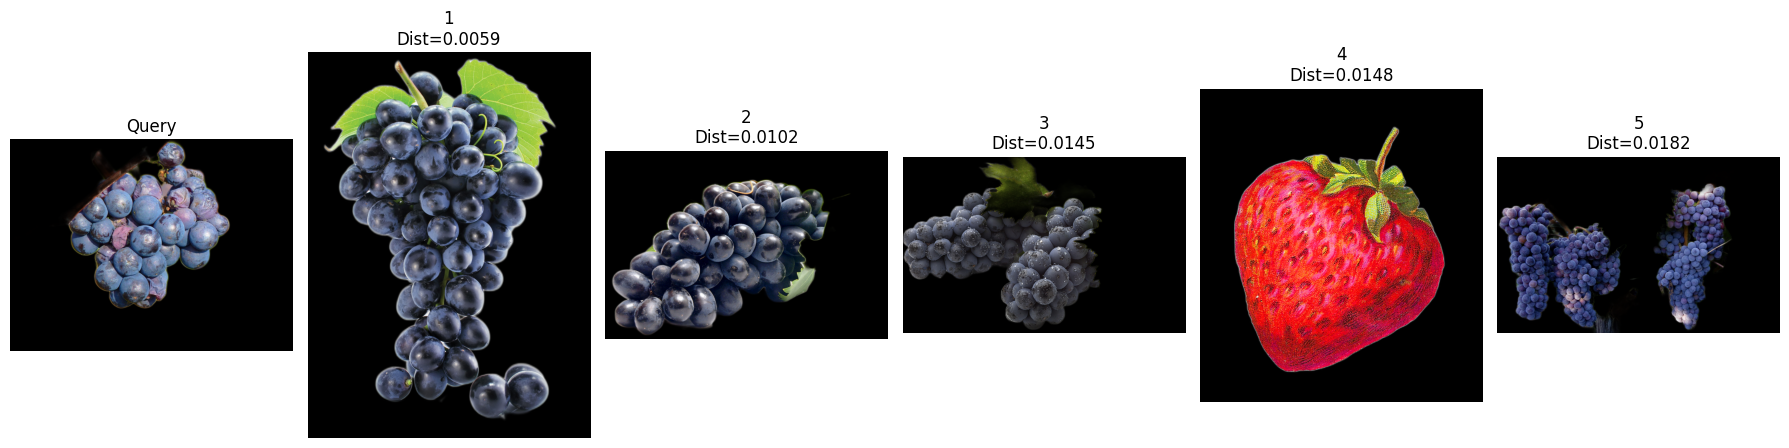


🔍 Query: kiwi_test.png


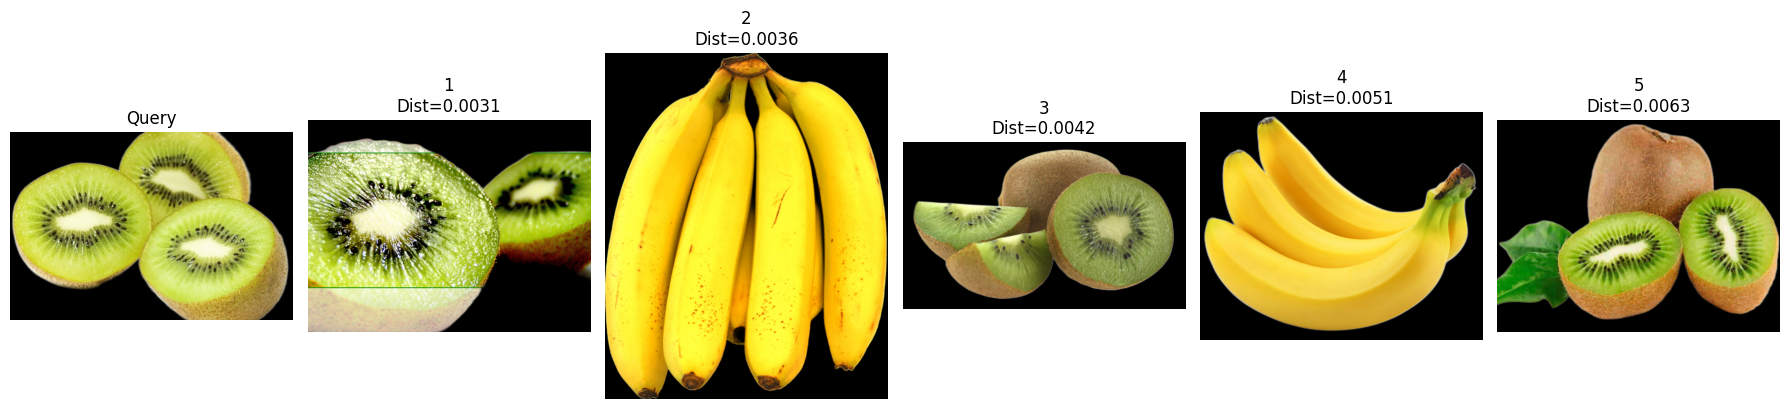


🔍 Query: pisang_test.png


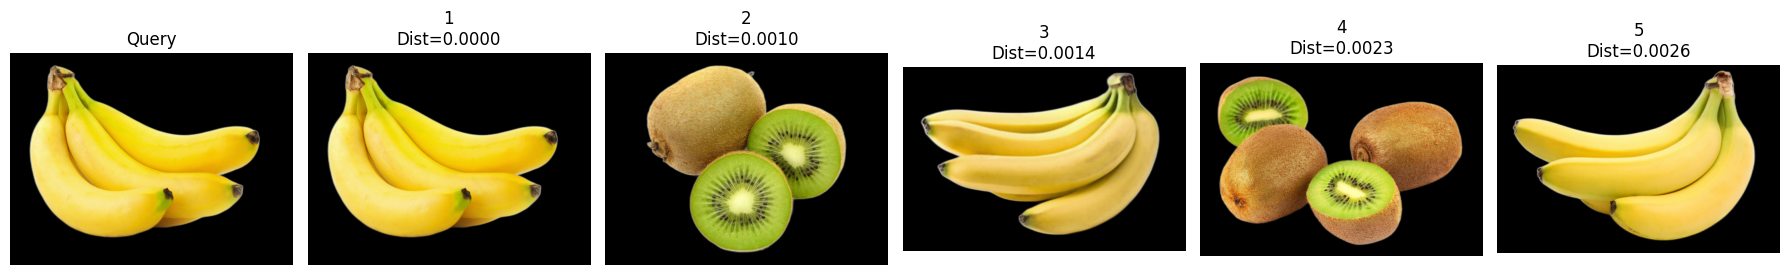


🔍 Query: stroberi_test.png


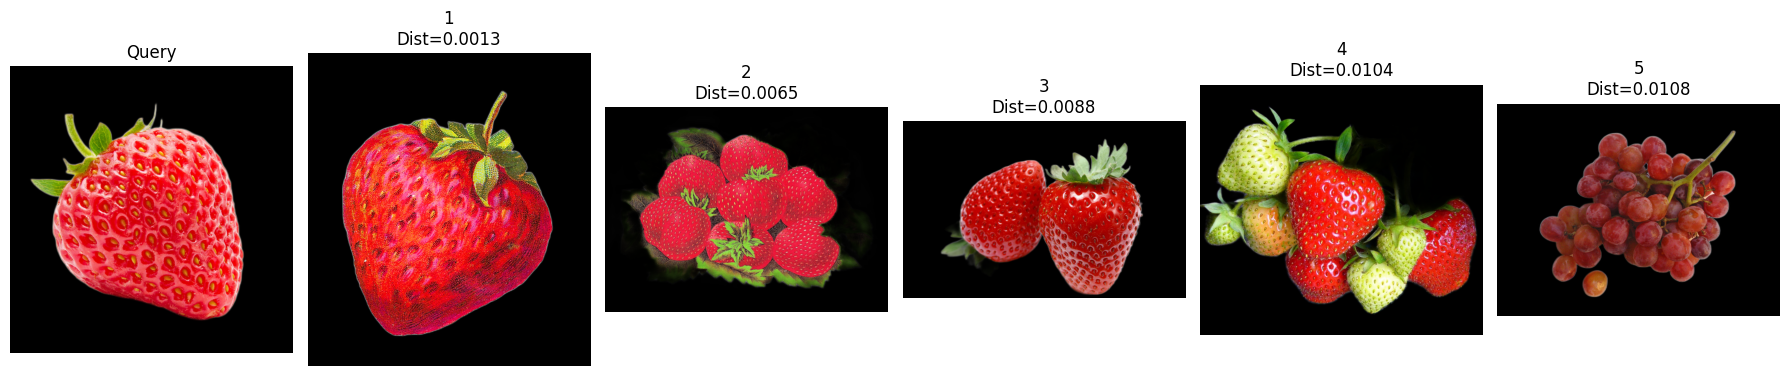

In [7]:
run_cbir_search_cosine(
    query_folder="query",
    db_features_color=color_features_db,
    db_features_glcm=glcm_features_db,
    db_features_shape=shape_features_db
)

## Evaluasi

### Hitung Precision@5 sederhana (berapa yang sekelas).

In [11]:
def _safe_norm(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    n = np.linalg.norm(x)
    return x / n if n > 0 else x

synonym_map = {
    "grapes": "anggur", "anggur": "anggur",
    "banana": "pisang", "pisang": "pisang",
    "strawberry": "stroberi", "strawberi": "stroberi",
    "cherry": "ceri", "ceri": "ceri",
    "apple": "apel", "apel": "apel",
    "orange": "jeruk", "jeruk": "jeruk",
    "mango": "mangga", "mangga": "mangga",
    "kiwi": "kiwi",
    "chickoo": "sawo", "sapota": "sawo", "sawo": "sawo",
}

def canonical_label_from_path(path_or_name: str) -> str:
    # 1) coba dari parent folder (kalau ada)
    parent = os.path.basename(os.path.dirname(path_or_name)).strip().lower()
    if parent and parent not in {".", "", "db", "query"}:
        base = parent
    else:
        # 2) dari nama file
        base = os.path.splitext(os.path.basename(path_or_name))[0].lower()
        # ambil token alfabet pertama (pisahkan spasi, underscore, dash, titik)
        tokens = [t for t in re.split(r"[\s_\-\.]+", base) if t]
        base = next((t for t in tokens if t.isalpha()), tokens[0] if tokens else base)

    # 3) samakan ke label kanonik
    return synonym_map.get(base, base)

# ===== Builder DB gabungan (pakai fungsi combine_features milikmu) =====
def build_combined_db(db_color, db_glcm, db_shape, w_color=0.4, w_glcm=0.3, w_shape=0.3):
    combined = {}
    all_keys = set(db_color.keys()) | set(db_glcm.keys()) | set(db_shape.keys())
    for name in all_keys:
        cf = db_color.get(name)
        gf = db_glcm.get(name)
        sf = db_shape.get(name)
        vec = combine_features(cf, gf, sf, w_color=w_color, w_glcm=w_glcm, w_shape=w_shape)
        combined[name] = vec
    return combined

# ===== Evaluasi Precision@K untuk satu konfigurasi =====
def evaluate_precision_at_k(query_folder, config="A", top_k=5, method="cosine",
                            db_color=None, db_glcm=None, db_shape=None,
                            w_color=0.4, w_glcm=0.3, w_shape=0.3):
    assert config in {"A", "B", "C"}
    per_query_scores = []
    details = []

    # Siapkan DB fitur sesuai konfigurasi
    if config == "A":
        db_feats = {k: _safe_norm(v) for k, v in (db_color or {}).items()}
    elif config == "B":
        db_feats = {k: _safe_norm(v) for k, v in (db_glcm or {}).items()}
    else:  # "C"
        db_feats = build_combined_db(db_color or {}, db_glcm or {}, db_shape or {},
                                     w_color=w_color, w_glcm=w_glcm, w_shape=w_shape)

    # Loop semua query
    for qname in sorted(os.listdir(query_folder)):
        if not qname.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        q_path = os.path.join(query_folder, qname)
        q_label = canonical_label_from_path(q_path)

        # Ekstrak fitur query sesuai config
        if config == "A":
            q_vec, _ = extract_color_features(q_path)
            q_vec = _safe_norm(q_vec) if q_vec is not None else np.zeros(1)
        elif config == "B":
            q_vec, _ = extract_glcm_features(q_path)
            q_vec = _safe_norm(q_vec) if q_vec is not None else np.zeros(1)
        else:  # "C"
            cq, _ = extract_color_features(q_path)
            gq, _ = extract_glcm_features(q_path)
            sq, _ = extract_shape_features(q_path)
            q_vec = combine_features(cq, gq, sq, w_color=w_color, w_glcm=w_glcm, w_shape=w_shape)

        # Cari Top-K
        results = search_similar_images(q_vec, db_feats, method=method, top_k=top_k)

        # Hitung Precision@K
        hits = 0
        ranked = []
        for fname, dist in results:
            r_label = canonical_label_from_path(fname)
            ranked.append((fname, dist, r_label))
            if r_label == q_label:
                hits += 1
        prec = hits / top_k
        per_query_scores.append(prec)
        details.append({
            "query": qname,
            "label": q_label,
            "precision_at_{}".format(top_k): prec,
            "ranked": ranked,
        })

    avg_precision = float(np.mean(per_query_scores)) if per_query_scores else 0.0
    return avg_precision, details


### Bandingkan 3 konfigurasi:
A. Warna B. GLCM C. Gabungan (warna+GLCM+bentuk).

In [ ]:
def evaluate_all_configs(query_folder="query", top_k=5, method="cosine",
                         db_color=None, db_glcm=None, db_shape=None,
                         w_color=0.4, w_glcm=0.3, w_shape=0.3, verbose=True):
    results = {}
    for cfg, label in [("A", "Warna"), ("B", "GLCM"), ("C", "Gabungan")]:
        avg_p, detail = evaluate_precision_at_k(
            query_folder=query_folder,
            config=cfg, top_k=top_k, method=method,
            db_color=db_color, db_glcm=db_glcm, db_shape=db_shape,
            w_color=w_color, w_glcm=w_glcm, w_shape=w_shape
        )
        results[cfg] = {"label": label, "precision_at_{}".format(top_k): avg_p, "details": detail}
        if verbose:
            print(f"[{cfg} - {label}]  Avg Precision@{top_k}: {avg_p:.3f}")
    return results

### Output

In [13]:
eval_results = evaluate_all_configs(
    query_folder="query",
    top_k=5,
    method="cosine",
    db_color=color_features_db,
    db_glcm=glcm_features_db,
    db_shape=shape_features_db,
    w_color=0.4, w_glcm=0.3, w_shape=0.3
)

[A – Warna]  Avg Precision@5: 0.700
[B – GLCM]  Avg Precision@5: 0.500
[C – Gabungan]  Avg Precision@5: 0.700


In [15]:
print("Detail (config C - Gabungan):")
for r in eval_results["C"]["details"]:
    print(f"- {r['query']} | label={r['label']} | P@5={r['precision_at_5']:.2f}")

Detail (config C - Gabungan):
- anggur_test.png | label=anggur | P@5=0.80
- kiwi_test.png | label=kiwi | P@5=0.60
- pisang_test.png | label=pisang | P@5=0.60
- stroberi_test.png | label=stroberi | P@5=0.80
